<a name='1'></a>
## Import Packages and load data

In [1]:
### -*- coding: utf-8 -*-
"""
Created on Mon May 24 13:26:13 2021

@author: kjsanche

Description: 
A function to load the 5 minute granules from MODIS channel 1 
(0.65 microns) and the contrail mask for ML with a CNN.

To do:

-organize/markdown/comment code


Input:
Path   (string)
 
        
        
Output:
MODISCh1 (2D uint32)
MASK     (2D uint16)
"""


from matplotlib import pyplot as plt
import matplotlib as mpl
from itertools import compress
%matplotlib inline
import numpy as np
import struct
import os
import glob
import random
#from format_input import *
from UNET_Functions import unet_model, summary
from Sat_contrail_read import Extract_RawDef, extract_img, extract_mask, extract_imglist, get_model_memory_usage
import tensorflow as tf
import sys
sys.path.append('/home/kjsanche/Desktop/Projects/loss')
from loss_function import *
from tensorflow.python.ops.metrics_impl import false_positives, false_negatives
import tensorflow.keras.metrics as tfm
#import tensorflow_addons as tfa
#from focal_loss import BinaryFocalLoss, SparseCategoricalFocalLoss


#config = tf.config.experimental
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)

sys_details = tf.sysconfig.get_build_info()
print(sys_details)
cudnn_version = sys_details["cudnn_version"]
cuda_version = sys_details["cuda_version"]

print('cuda version: ', cuda_version)
print('cudNN version: ',cudnn_version)
print('TF version: ', tf.version.VERSION)




VALIDATION_SPLIT = .2
BATCH_SIZE = 2048 #keep 2048 for 64x64 images
EPOCHS = 3000
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API
IMG_W=64
IMG_H=64
N_FILTERS = 64
N_CHANNELS = 7
LEARNING_RATE = 0.00003
VERSION = 'TEST'
ModelV = '02'
TFrecord_path ='/home/kjsanche/Desktop/TFrecords/'
Models_path ='/home/kjsanche/Desktop/ExternalSSD/SatContrailData/Models/'
#TFrecord_path = '/home/kjsanche/Desktop/Projects/Sat_Contrail_Unet/Unet/content/'

filenames=sorted(tf.io.gfile.glob([TFrecord_path + '*v' + VERSION + '.tfrecords']))
#oldMask_filenames=sorted(tf.io.gfile.glob([TFrecord_path + '*v' + VERSION +'old_mask.tfrecords']))
#may need to sort file names first

#random.shuffle(filenames)
#split_training = int(len(filenames) * VALIDATION_SPLIT*2)
split_val = int(len(filenames) * VALIDATION_SPLIT)



training_filenames = filenames[split_val:]
validation_filenames = filenames[:split_val]
test_filenames = sorted(tf.io.gfile.glob([TFrecord_path + '*vMODIS7test.tfrecords']))
test_OldMASKfilenames = sorted(tf.io.gfile.glob([TFrecord_path + '*vMODIS7testold_mask.tfrecords']))

validation_steps = len(validation_filenames) // BATCH_SIZE
test_steps = len(test_filenames) // BATCH_SIZE
steps_per_epoch = len(training_filenames)  // BATCH_SIZE

print(len(test_filenames))
print(len(test_OldMASKfilenames))

2022-06-23 10:10:46.194821: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


OrderedDict([('cpu_compiler', '/home/builder/ktietz/aggregate/tensorflow_recipes/ci_cpu/tensorflow-base_1614583966145/_build_env/bin/x86_64-conda_cos6-linux-gnu-gcc'), ('cuda_compute_capabilities', ['compute_35', 'compute_52', 'compute_60', 'compute_61', 'compute_70', 'compute_75']), ('cuda_version', '10.1'), ('cudnn_version', '7'), ('is_cuda_build', True), ('is_rocm_build', False)])
cuda version:  10.1
cudNN version:  7
TF version:  2.4.1
100
100


In [2]:
def parse_tfr_element(element):
    #it's kinda an outline of the structure we now want to create
    data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'depth':tf.io.FixedLenFeature([], tf.int64),
      'raw_label':tf.io.FixedLenFeature([], tf.string),#tf.string = bytestring (not text string)
      'raw_image' : tf.io.FixedLenFeature([], tf.string),#tf.string = bytestring (not text string)
    }


    content = tf.io.parse_single_example(element, data)

    height = content['height']
    width = content['width']
    depth = content['depth']
    raw_label = content['raw_label']
    raw_image = content['raw_image']


    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.float16)

    feature = tf.reshape(feature, shape=[height,width,depth])
    label = tf.io.parse_tensor(raw_label, out_type=tf.int8)
    label = tf.reshape(label, shape=[height,width])
    return (feature, label)

def get_batched_dataset(filenames, testing = False):
    option_no_order = tf.data.Options()
    if testing:
        option_no_order.experimental_deterministic = True
    else:
        option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)
    dataset = dataset.map(parse_tfr_element, num_parallel_calls=AUTO)

    dataset = dataset.cache() # This dataset fits in RAM
    dataset = dataset.repeat()
    if not testing:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) 
    dataset = dataset.prefetch(AUTO) #

    return dataset

def get_training_dataset(training_filenames):
    return get_batched_dataset(training_filenames)

def get_validation_dataset(validation_filenames):
    return get_batched_dataset(validation_filenames)

def get_test_dataset(test_filenames):
    return get_batched_dataset(test_filenames, testing = True)

def get_dataset_large(tfr_dir:str="/home/kjsanche/Desktop/Projects/Sat_Contrail_Unet/Unet/content/", pattern:str="*large_images.tfrecords"):
    files = glob.glob(tfr_dir+pattern, recursive=False)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(parse_tfr_element)

    return dataset
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        #print(i)
        #print(display_list[i].shape)
        if i == 0:
            plt.imshow(np.float32(display_list[i][:,:,7]))#-display_list[i][:,:,1]))
        else:
            plt.imshow(np.float32(1*display_list[i]))
        plt.axis('off')
    plt.show()

The below code cell uses a lot of memory and therefore should only be used for testing and not be used during training.

In [3]:
def FocalTverskyLoss(targets, inputs, alpha=0.5, beta=0.5, gamma=1, smooth=1e-6):
        '''
        ... in the case of α=β=0.5 the Tversky index simplifies to be 
        the same as the Dice coefficient, which is also equal to the F1 
        score. With α=β=1, Equation 2 produces Tanimoto coefficient, and 
        setting α+β=1 produces the set of Fβ scores. Larger βs weigh 
        recall higher than precision (by placing more emphasis on false negatives).
        '''
        targets = tf.cast(targets,tf.float32)
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky

## unet.save_weights(Models_path+'model')
#unet = tf.keras.models.load_model(Models_path+'model')

In [4]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))
def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

In [5]:

def rescale_image(img):
    #if NCHANNELS-5>0:
    NCHANNELS = 7
    tmp = img[:,:,:,NCHANNELS-5:]
    tmp[tmp==17000]=0
    img[:,:,:,NCHANNELS-5:]=tmp
    BT_rng = np.float64([17000, 34000]) #this range is good for 4 upper channels. assuming range of 170-340 K (BT is multiplied by 100)
    img[:,:,:,NCHANNELS-5:-1] = (img[:,:,:,NCHANNELS-5:-1] * ((BT_rng[1]-BT_rng[0])/2) ) + np.mean(BT_rng)
    BT_rng = np.float64([0, 66535]) #lower 3 channels have a much larger range.
    img[:,:,:,:NCHANNELS-5] = (img[:,:,:,:NCHANNELS-5] * ((BT_rng[1]-BT_rng[0])/2) ) + np.mean(BT_rng)
    return img
    #else:
    #   img_rotated[img_rotated==0]=17000
    #   BT_rng = np.float64([17000, 34000]) #this range is good for 4 upper channels. assuming range of 170-340 K (BT is multiplied by 100)
    #   img_rotated[:,:,:,:-1] = (img_rotated[:,:,:,:-1]-np.mean(BT_rng)) / ((BT_rng[1]-BT_rng[0])/2) 

In [6]:
def image_IOU(mask1, mask2):
    inter = 0
    union = 0
    #for _, mask in image_ds:
    #mask = mask.numpy()
    mask1[mask1>1]=1
    mask2[mask2>1]=1
    mask1[mask1<1]=0
    mask2[mask2<1]=0

    #create list of true indicies for both masks
    a = list(compress(range(len(mask1[:,:].flatten())), mask1[:,:].flatten()))
    b = list(compress(range(len(mask2[:,:].flatten())), mask2[:,:].flatten()))

    IOU = len(list(set(a).intersection(b)))/(len(list(set(a).union(b)))+1e-6)
    inter += len(list(set(a).intersection(b)))
    union += len(list(set(a).union(b)))
    #print(f"intersection = {len(list(set(a).intersection(b)))}")
    #print(f"union = {len(list(set(a).union(b)))}")
    #print(f"IOU ={IOU}")
    return inter, union, IOU

In [7]:
def IOU_test(dataset=None,num=1):
    """
    extract IOU values for each image
    """

    for test_data, oldMask_data in dataset.take(1):
        image, mask = test_data
        image2, old_mask = oldMask_data


        #_, _, _, FN, FP, TP, TN, _ = unet.evaluate(image.numpy(), mask.numpy(), verbose=2)
        #IOU = np.divide(TP,np.add(FN,np.add(TP,FP)))
        #print(f'IOU = {IOU}')

        #rescale image (scaled to valuse between 0 and 1 previously for training)
        origImage = rescale_image(np.array(image,dtype=float))

        #compile full image from slices
        fullimage = np.empty([2048, 4096, 7])
        for i in range(origImage.shape[-1]):
            fullimage[:,:,i] = unblockshaped(origImage[:,:,:,i], 2048, 4096)

        #compile full masks from slices
        fullOldMask = unblockshaped(old_mask.numpy(), 2048, 4096)
        fullNewMask = unblockshaped(mask.numpy(), 2048, 4096)

        #run model for case to produced predicted mask and plot
        #pred_mask = unet.predict(image)
        #fullPredMask = unblockshaped(pred_mask, 2048, 4096)
        
        #evalutate the model predicted masks and the old masks
        #Pinter, Punion, PIOU = image_IOU(np.float32(fullNewMask), fullPredMask)
        Oldinter, Oldunion, OldIOU = image_IOU(np.float32(fullOldMask), np.float32(fullNewMask))
        
        #plot image and masks
        print('satellite image')
        fig = plt.figure()
        plt.imshow(fullimage[:,:,4]-fullimage[:,:,5], cmap = 'gray')
        plt.show()
        fig = plt.figure()
        #print('old mask')
        #plt.imshow(np.float32(fullOldMask), cmap = 'gray')
        #plt.show()
        #fig = plt.figure()
        #print('new mask')
        #plt.imshow(np.float32(fullNewMask), cmap = 'gray')
        #plt.show()
        #print('predicted mask')
        #fig = plt.figure()
        #plt.imshow(np.float32(fullPredMask), cmap = 'gray')
        #plt.show()
    return Oldinter, Oldunion, OldIOU


In [15]:
def IOU_test2(dataset=None,num=1,fname=''):
    """
    extract IOU values for each image
    """

    for test_data, oldMask_data in dataset.take(1):
        image, mask = test_data
        image2, old_mask = oldMask_data


        #_, _, _, FN, FP, TP, TN, _ = unet.evaluate(image.numpy(), mask.numpy(), verbose=2)
        #IOU = np.divide(TP,np.add(FN,np.add(TP,FP)))
        #print(f'IOU = {IOU}')

        #rescale image (scaled to valuse between 0 and 1 previously for training)
        origImage = rescale_image(np.array(image,dtype=float))

        #compile full image from slices
        fullimage = np.empty([2048, 4096, 7])
        for i in range(origImage.shape[-1]):
            fullimage[:,:,i] = unblockshaped(origImage[:,:,:,i], 2048, 4096)

        #compile full masks from slices
        fullOldMask = unblockshaped(old_mask.numpy(), 2048, 4096)
        fullNewMask = unblockshaped(mask.numpy(), 2048, 4096)

        #run model for case to produced predicted mask and plot
        #pred_mask = unet.predict(image)
        #fullPredMask = unblockshaped(pred_mask, 2048, 4096)
        
        #evalutate the model predicted masks and the old masks
        #Pinter, Punion, PIOU = image_IOU(np.float32(fullNewMask), fullPredMask)
        Oldinter, Oldunion, OldIOU = image_IOU(np.float32(fullOldMask), np.float32(fullNewMask))
        cmap = mpl.colors.ListedColormap(["black", "maroon", "lightcoral", "green"])
        if OldIOU > 0.15 and OldIOU < 0.19:
            print(f'IOU = {OldIOU}, File = {fname}')
            #plot image and masks
            print('satellite image')
            fig = plt.figure()
            plt.imshow(fullimage[:,:,4]-fullimage[:,:,5], cmap = 'gray')#, vmin=-1, vmax=5.5)
            plt.colorbar()
            plt.xlim([400, 1600])
            plt.ylim([1800, 800])
            plt.xticks(np.arange(400, 1600, 200))
            plt.yticks(np.arange(1800, 800, -200))
            plt.grid(which='major', axis='both', linestyle='-',linewidth=0.2)
            plt.show()
            fig = plt.figure()
            print('mask')
            plt.imshow(np.float32(fullNewMask)*2+np.float32(fullOldMask), cmap = cmap, vmin=0, vmax=4)
            cbar = plt.colorbar(ticks=np.linspace(0,3,4)+0.5)
            cbar.ax.set_yticklabels(['True Negative', 'False Positive', 'False Negative', 'True Positive'])
            plt.xlim([400, 1600])
            plt.ylim([1800, 800])
            plt.xticks(np.arange(400, 1600, 200))
            plt.yticks(np.arange(1800, 800, -200))
            plt.grid(which='major', axis='both', linestyle='-',linewidth=0.2)

            plt.show()
            #fig = plt.figure()
            #print('new mask')
            #plt.imshow(np.float32(fullNewMask), cmap = 'gray')
            #plt.show()
            #print('predicted mask')
            #fig = plt.figure()
            #plt.imshow(np.float32(fullPredMask), cmap = 'gray')
            #plt.show()
    return Oldinter, Oldunion, OldIOU


100
IOU = 0.18944767307969396, File = /home/kjsanche/Desktop/TFrecords/1_1MOD021KM-A2018091.1005vMODIS7test.tfrecords
satellite image


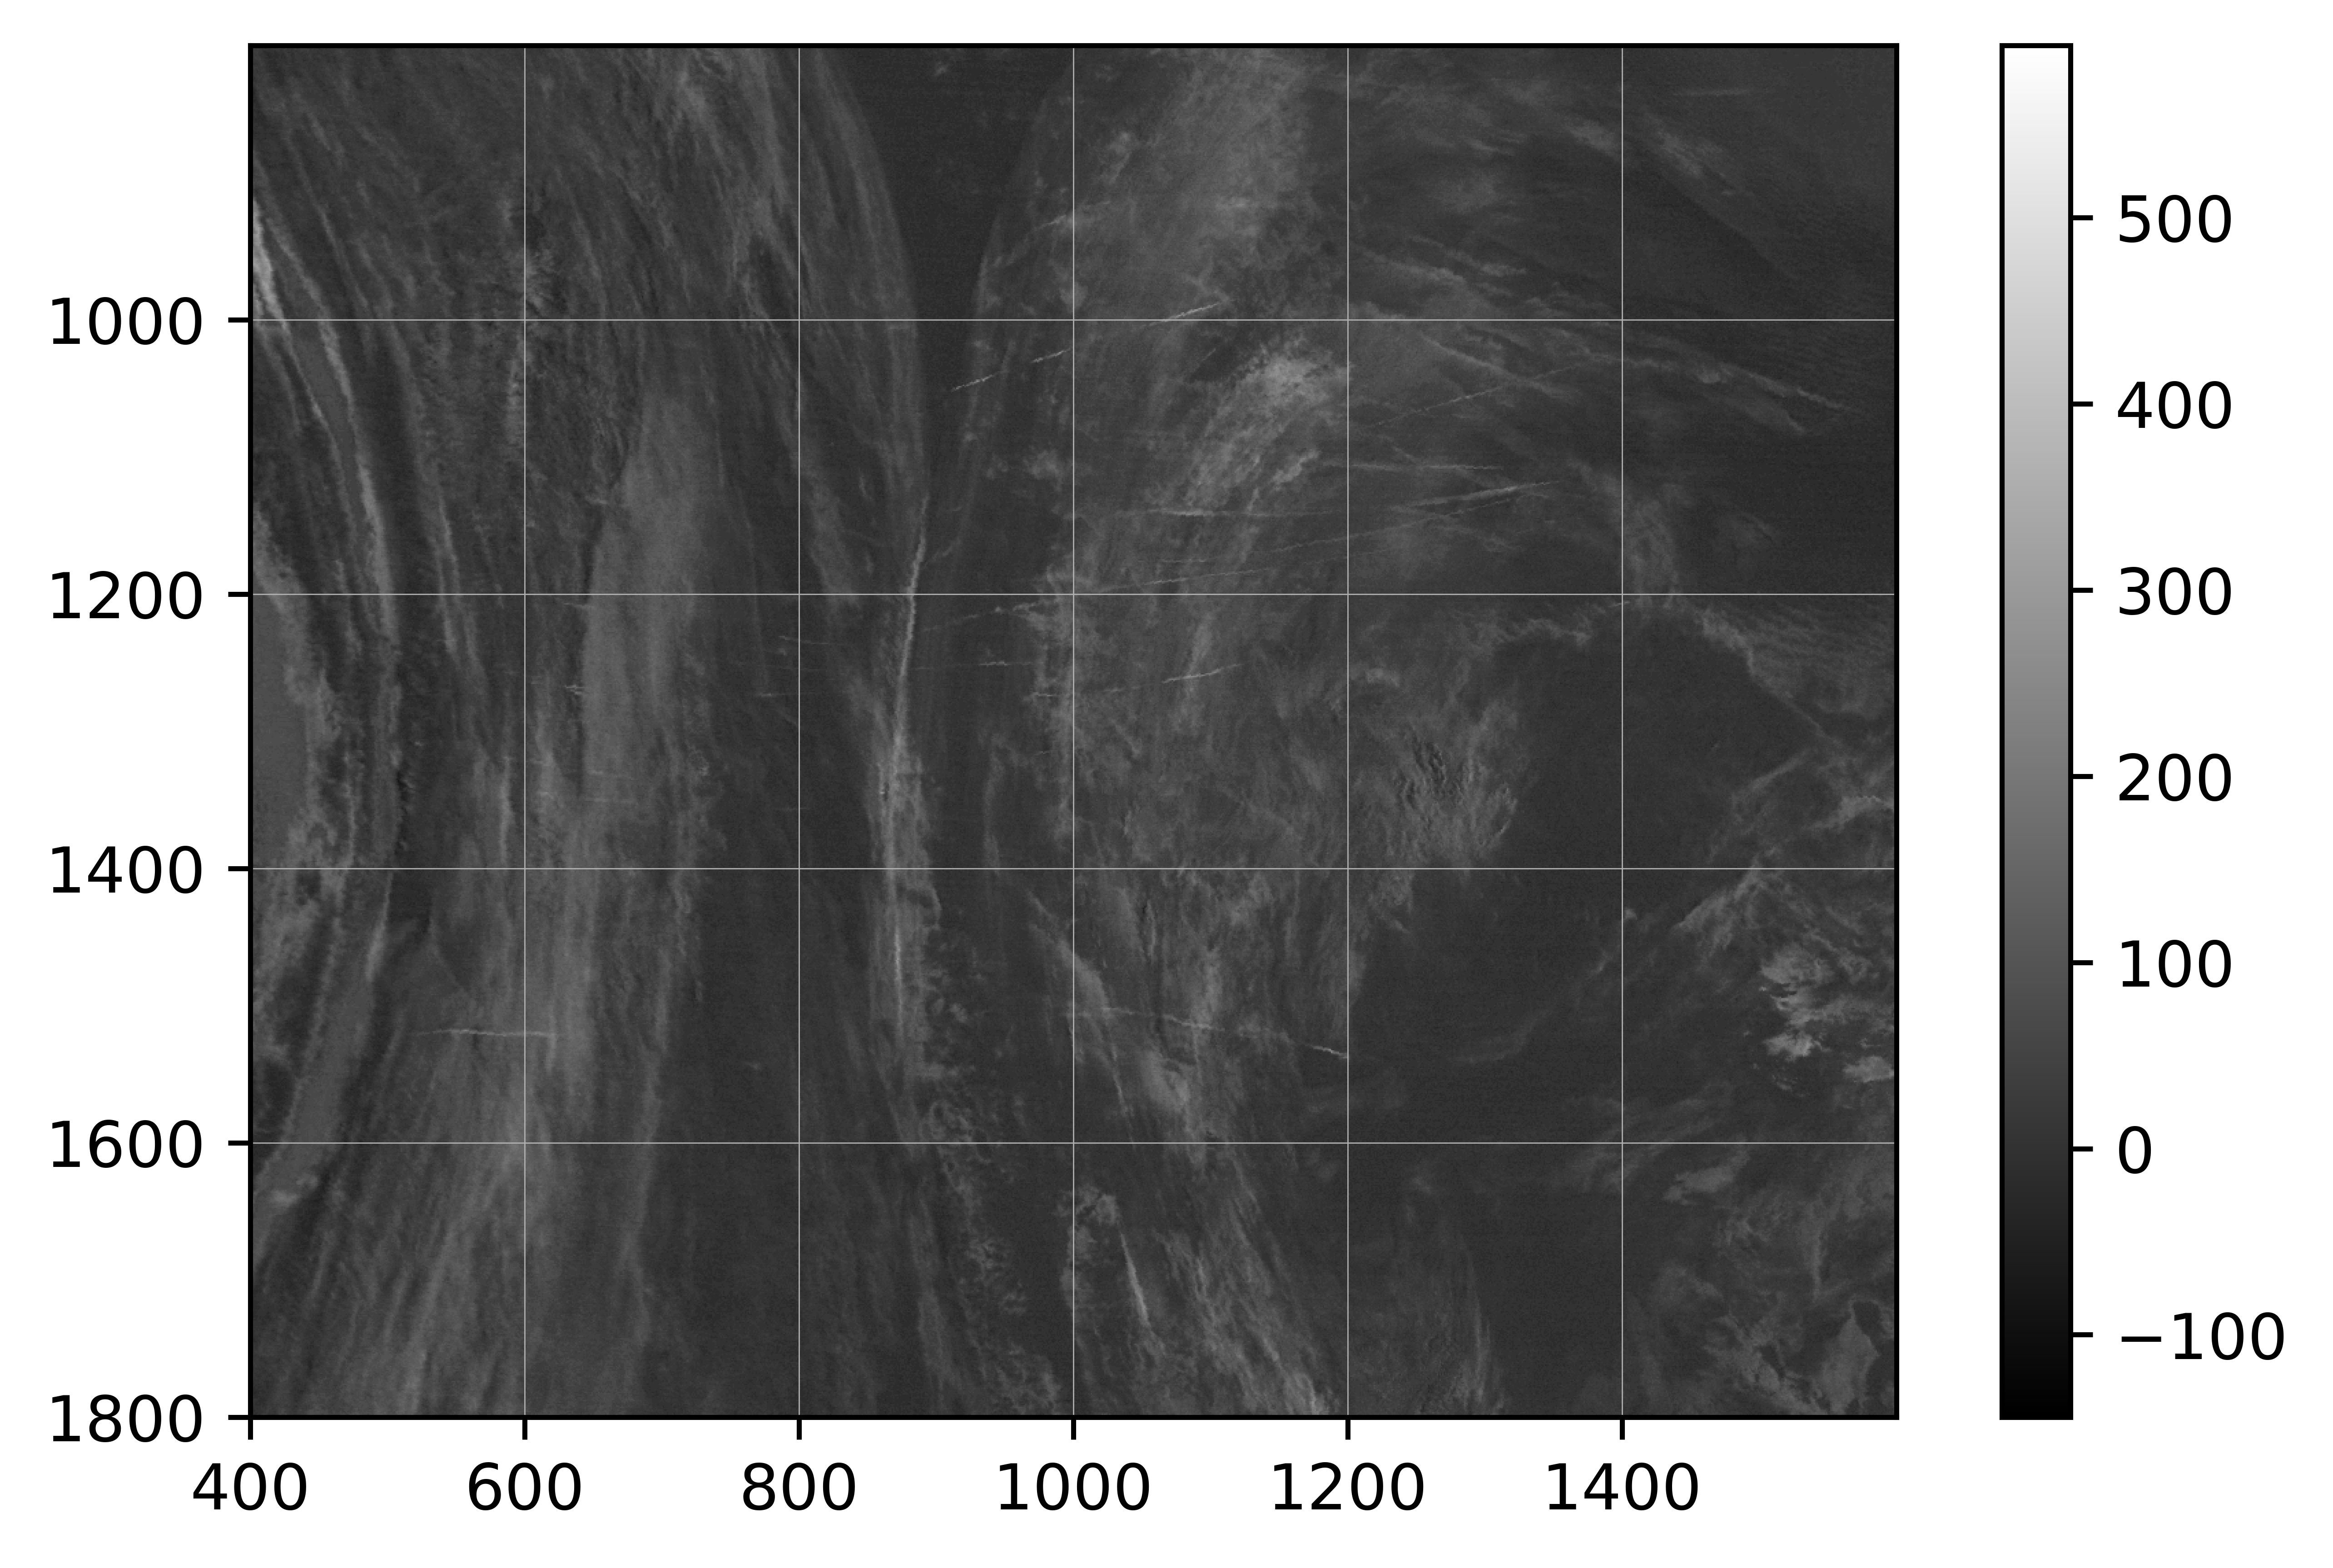

mask


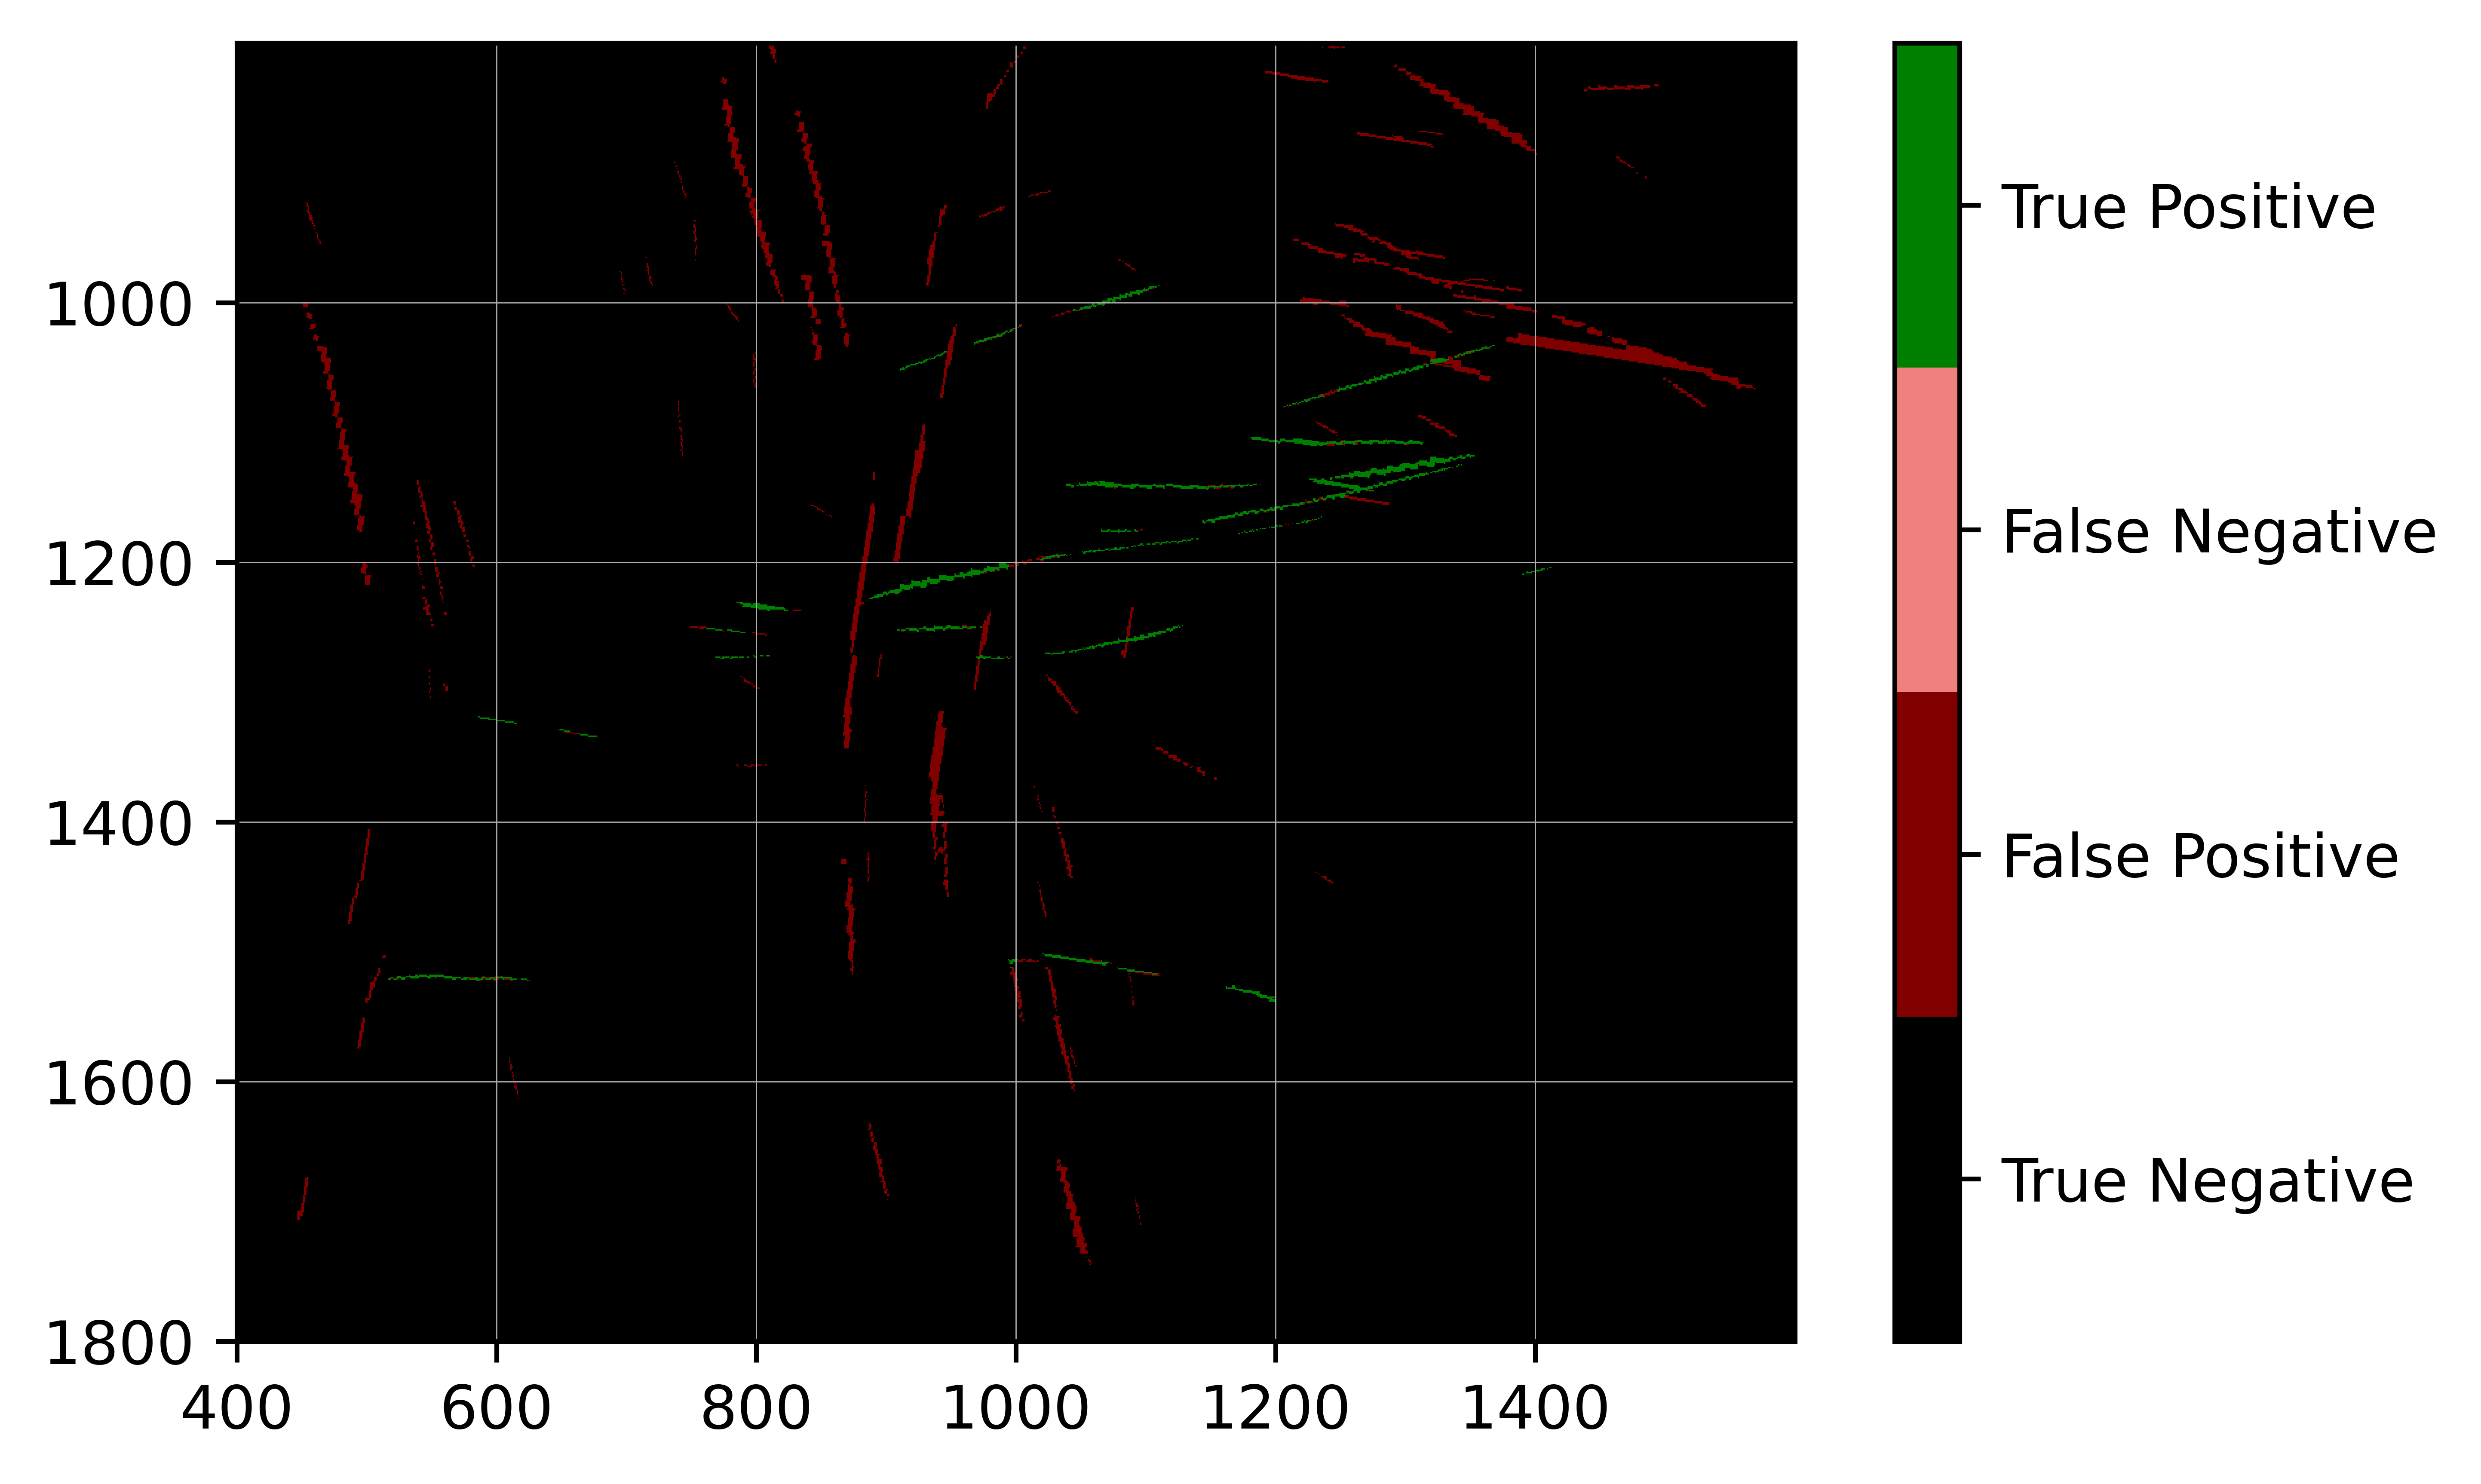

In [16]:
import matplotlib as mpl
from itertools import compress
mpl.rcParams['figure.dpi']= 1000
#test_filenames = filenames
print(len(test_filenames))
Oldinter = np.empty([len(test_filenames)])
Oldunion = np.empty([len(test_filenames)])
OldIOU = np.empty([len(test_filenames)])
Pinter = np.empty([len(test_filenames)])
Punion = np.empty([len(test_filenames)])
PIOU = np.empty([len(test_filenames)])
for cnt, (fname, fnameoldMask) in enumerate(zip(test_filenames,test_OldMASKfilenames)): 
    fname = '/home/kjsanche/Desktop/TFrecords/1_1MOD021KM-A2018091.1005vMODIS7test.tfrecords'
    fnameoldMask = '/home/kjsanche/Desktop/TFrecords/1_1MOD021KM-A2018091.1005vMODIS7testold_mask.tfrecords'
    test_data = get_test_dataset(fname)
    #print(fname)
    oldMask_data = get_test_dataset(fnameoldMask)
    combined_dataset = tf.data.Dataset.zip((test_data,oldMask_data))
    #show_predictions(combined_dataset, 1)
    #Oldinter[cnt], Oldunion[cnt], OldIOU[cnt], Pinter[cnt], Punion[cnt], PIOU[cnt] = IOU_test(combined_dataset, 1)
    Oldinter[cnt], Oldunion[cnt], OldIOU[cnt] = IOU_test2(combined_dataset, 1,fname)
    break


In [10]:
fnameoldMask

'/home/kjsanche/Desktop/TFrecords/1_1MOD021KM-A2018091.1820vMODIS7testold_mask.tfrecords'

In [11]:
print(sum(Oldinter)/sum(Oldunion))
print(sum(Pinter)/sum(Punion))

0.16827666756876095
nan
